In [1]:
from pyvis.network import Network
import networkx as nx
import numpy as np
import scipy
from matplotlib import pyplot as plt 

## Read RNA Seq Dataset

Data Source: https://www.cell.com/cell/fulltext/S0092-8674(18)30955-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418309553%3Fshowall%3Dtrue

RNA_seq_matrix is a sparse matrix where each entry stores gene expression "value" for specific gene (row) and cell (column).
The gene expression ranges from 0 to some positive integer which represents the degree to .

Each cell belongs to certain cell type, and each cell type conveys a hidden distibution of gene expression which distinguishes itself to other cell types.

In [2]:
from scipy import sparse, io

RNA_seq_matrix = io.mmread("data/FC_data_LRcell.mm.txt")

In [3]:
print("RNA_seq_matrix.shape: ", RNA_seq_matrix.shape)
print("Non-zero entry count=%d (%.2f%%)" % (RNA_seq_matrix.getnnz(), 
      RNA_seq_matrix.getnnz()/RNA_seq_matrix.shape[0]/RNA_seq_matrix.shape[1]*100))
print("Entry analysis: min=%d, max=%d, mean=%.3f" % (RNA_seq_matrix.min(), 
                                                     RNA_seq_matrix.max(),
                                                     RNA_seq_matrix.mean(),
                                                    ))

RNA_seq_matrix.shape:  (15976, 71639)
Non-zero entry count=137124604 (11.98%)
Entry analysis: min=0, max=1711, mean=0.251


Moreover, the data is reletively large scale and may contain noisy data, hence it is beneficial to **sample a subset** for further analysis.

### cell down-sampling

In [4]:
# cell analysis
cell_vec = RNA_seq_matrix.sum(0)
print("cell_vec shape =", cell_vec.shape)
print("Entry analysis: min=%d, max=%d, mean=%.3f, std=%.3f" % (cell_vec.min(), cell_vec.max(), 
                                                               cell_vec.mean(), cell_vec.std()))

cell_vec shape = (1, 71639)
Entry analysis: min=611, max=73424, mean=4009.060, std=3355.501


Because the original data is stored in R data format, and R is powful for analysing, plotting big scale sparse data, the above images are generated by R scripts.

```R
data = readRDS("data/FC_data_LRcell.RDS")
hist(log10(colSums(data)), main="Histogram of Total Gene Expression Per Cell", ylab="log10")
```
![column](data/Column.hist)

From the histogram, there exists a potential threshold, 10^3.3, for dicarding low gene expression cells.  
However, to reserve the distribution of different cell types, I follow their frequencies in the dataset.  
The dataset contains **71639** cells, and I plan to downsample it to around **7K** (10%) cells.

len(cell_name_type_dict)=71639, len(cell_type)=81
cell_type_counter: Counter({'FC_6-1': 15003, 'FC_6-3': 11719, 'FC_6-4': 11549, 'FC_8-1': 4132, 'FC_9-4': 1772, 'FC_4-1': 1501, 'FC_12-1': 1490, 'FC_3-3': 1451, 'FC_12-3': 1336, 'FC_7-6': 1213, 'FC_3-7': 1010, 'FC_12-4': 926, 'FC_3-1': 863, 'FC_9-1': 778, 'FC_9-5': 734, 'FC_7-3': 708, 'FC_8-2': 690, 'FC_3-12': 678, 'FC_1-1': 658, 'FC_3-4': 655, 'FC_3-8': 610, 'FC_5-1': 567, 'FC_2-7': 533, 'FC_11-1': 500, 'FC_1-2': 484, 'FC_13-2': 442, 'FC_2-9': 442, 'FC_9-3': 435, 'FC_3-9': 425, 'FC_10-1': 417, 'FC_13-1': 384, 'FC_1-5': 376, 'FC_2-8': 376, 'FC_1-6': 359, 'FC_6-5': 332, 'FC_6-2': 325, 'FC_3-13': 318, 'FC_10-5': 267, 'FC_2-4': 242, 'FC_2-2': 241, 'FC_2-5': 224, 'FC_1-4': 223, 'FC_10-6': 217, 'FC_7-1': 204, 'FC_1-10': 202, 'FC_7-2': 200, 'FC_1-11': 193, 'FC_3-10': 192, 'FC_3-2': 188, 'FC_10-3': 185, 'FC_3-5': 177, 'FC_13-3': 156, 'FC_3-6': 153, 'FC_11-3': 149, 'FC_2-10': 148, 'FC_1-9': 145, 'FC_2-3': 131, 'FC_7-7': 129, 'FC_1-7': 118, 'FC_1

<BarContainer object of 81 artists>

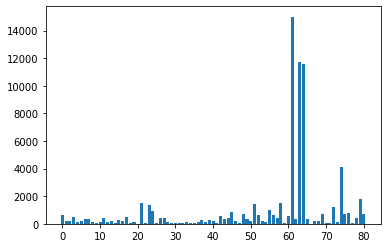

In [17]:
# Load cell type distribution
from collections import Counter
cell_name_type_tuple_list = []
cell_type_counter = Counter()
with open("data/FC_cells_annot.csv") as fopen:
    for line in fopen:
        cell_name, cell_type = line.strip().split(',')
        cell_name_type_tuple_list.append((cell_name, cell_type))
        cell_type_counter[cell_type] += 1
print("len(cell_name_type_dict)=%d, len(cell_type)=%d" % (len(cell_name_type_dict), len(cell_type_counter)))
print("cell_type_counter:", cell_type_counter)
plt.bar(np.arange(len(cell_type_counter)), cell_type_counter.values())

Finally kept 3599 cells


<BarContainer object of 81 artists>

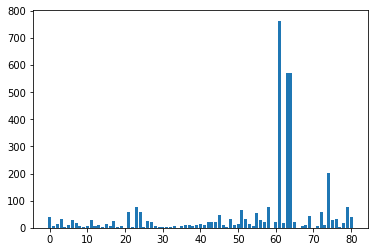

In [24]:
import random
cell_subsample_type_counter = {k: 0 for k, v in cell_type_counter.items()}
kept_cells = []
for idx, (cell_n, cell_t) in enumerate(cell_name_type_tuple_list):
    if random.random() <= 0.05:
        kept_cells.append(idx)
        cell_subsample_type_counter[cell_t] += 1
print("Finally kept %d cells" % (len(kept_cells)))
plt.bar(np.arange(len(cell_subsample_type_counter)), cell_subsample_type_counter.values())

From the above bar charts, it is obvious the original cell type distribution is approximately reserved.


### Gene Down-sampling

```R
hist(rowSums(data>0), main="Histogram of Cell Proportion Expressed Per Gene", ylab="Frequency")
```

![row](data/Row.hist)

From the above histogram, there are around 10K genes have cell frequency < 20K which means they are not significantly expressed among all cells in the dataset.  
The gene number after down-sampling is expected to have similar propotion in the original dataset, hence I choose 40K as the threshold.

In [25]:
# Gene analysis
gene_vec = RNA_seq_matrix.sum(1)
print("Gene vec shape", gene_vec.shape)

Gene vec shape (15976, 1)


In [30]:
kept_genes = []
for idx, s in enumerate(gene_vec[:,0]):
    if s > 40000:
        kept_genes.append(idx)
print("kept genes=", len(kept_genes))

kept genes= 1583


In [37]:
# save gene expression matrix
RNA_seq_matrix_sampled = RNA_seq_matrix.tocsr()[kept_genes, :][:, kept_cells]
print("After sampling, RNA_seq_matrix shape=", RNA_seq_matrix_sampled.shape)
RNA_seq_matrix = None
io.mmwrite("data/FC_data_LRcell.sampled.mm.txt", RNA_seq_matrix_sampled)

After sampling, RNA_seq_matrix shape= (1583, 3599)


In [38]:
# save attached information
with open('data/FC_data_LRcell.colnames.txt') as fopen, open('data/FC_data_LRcell.sampled.colnames.txt', 'w') as fwrite:
    for idx, line in enumerate(fopen):
        if idx in kept_cells:
            fwrite.write(line)
            
with open('data/FC_data_LRcell.rownames.txt') as fopen, open('data/FC_data_LRcell.sampled.rownames.txt', 'w') as fwrite:
    for idx, line in enumerate(fopen):
        if idx in kept_genes:
            fwrite.write(line)

# Build Bipartite Graph

Inspired by the author-venue bipartite graph, the RNA-seq matrix can be formulated as a bipartite graph whose vertices are gene vertices and cell vertices.

In [44]:
RNA_seq_matrix_sampled = io.mmread("data/FC_data_LRcell.sampled.mm.txt").tocsr()
with open("data/FC_data_LRcell.sampled.colnames.txt") as fopen:
    cell_names = [l.strip() for l in fopen.readlines()]
with open("data/FC_data_LRcell.sampled.rownames.txt") as fopen:
    gene_names = [l.strip() for l in fopen.readlines()]
print("RNA_seq_matrix_sampled shape=%s, cell_names cnt=%d, gene_names cnt=%d" % 
      (RNA_seq_matrix_sampled.shape, len(cell_names), len(gene_names)))

RNA_seq_matrix_sampled shape=(1583, 3599), cell_names cnt=3599, gene_names cnt=1583


In [46]:
B = nx.Graph()
# Add nodes
B.add_nodes_from(["g%d" % (i) for i in range(len(gene_names))], bipartite=0)
B.add_nodes_from(["c%d" % (i) for i in range(len(cell_names))], bipartite=1)
# Add edges
rows, cols = RNA_seq_matrix_sampled.nonzero()
edges_with_weights = [("g%d"%(r), "c%d"%(w), RNA_seq_matrix_sampled[r,w]) for (r, w) in zip(rows, cols)]
B.add_weighted_edges_from(edges_with_weights)

In [58]:
# Add cell types
cell_name_type_dict = {}
with open("data/FC_cells_annot.csv") as fopen:
    for line in fopen:
        cell_name, cell_type = line.strip().split(',')
        cell_name_type_dict[cell_name] = cell_type
node_attr_cell_type = {}
for idx, cell_name in enumerate(cell_names):
    cell_type = cell_name_type_dict[cell_name]
    node_attr_cell_type["c%d" % (idx)] = {"cell_type": cell_type}
nx.set_node_attributes(B, node_attr_cell_type)

# Graph Analysis

First, let's take a look at some basic stats.

In [ ]:
print("Gene-Cell Bipartitie Graph basic stat:\n", nx.info(B))
print("is_bipartite=", nx.is_bipartite(B))

Gene-Cell Bipartitie Graph basic stat:
 Name: 
Type: Graph
Number of nodes: 5182
Number of edges: 2916778
Average degree: 1125.7345
is_bipartite= True


Text(0, 0.5, 'Frequency')

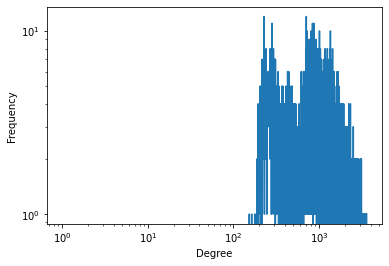

In [54]:
degree_freq = nx.degree_histogram(B)
plt.loglog(range(len(degree_freq)), degree_freq)
plt.xlabel("Degree")
plt.ylabel("Frequency")

From the degree distribution figure, the gene-cell graph does not follow the "Heavy-tailed distribution".  
This is attributed to the down-sampling strategy I applied to the original data since the low gene expression cells and genes are discarded.

In [ ]:
# Analysis for average_clustering
print("average clustering coeff=", nx.average_clustering(B))

It is important to see what the graph strcuture looks like.  
However, current graph is still too large to be plotted.  
For the visulization purpose, a random subgraph is presented.

In [ ]:
def filter_node(nid):
    nid_int = int(nid[1:])
    return (0 == nid_int % 100)
sg_view = nx.subgraph_view(B, filter_node=filter_node)
print(nx.info(sg_view))